# Tutorial 1.3: Cross validation to decide the polynomial order

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/1_3_cross_validation_keyhole_example.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import pandas as pd
import pysindy as ps
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.optimize import minimize
import xgboost
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

In [2]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_list, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_list = output_list
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in, self.basis3_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_list].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in, basis3_in = self.basis_list
        return basis1_in, basis2_in, basis3_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + coef[1] * self.basis2_in + coef[2] * self.basis3_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        # print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        # print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def predict(self, X, coef, coef_w, degree):
        '''
        Predict
        '''
        pi_in = np.prod(np.power(X, coef.reshape(-1,)), axis=1).reshape(1, -1)
        feats_train = self.parse_feats(pi_in, degree)
        pred = np.sum(np.multiply(feats_train, coef_w), axis=1)
        return pred

    def parse_feats(self, arr, degree=5):
        # prepare different degrees' features
        feats_list = []
        for degree_idx in range(degree+1):
            feats_list.append(arr**degree_idx)
        feats = np.vstack(feats_list).T
        return feats

    def fit_pattern_search(self, max_ps=10, degree=5, seed=0):
        idx = 0
        r2, basis_coef_final, reg_coef_final, coef_w_final = 0, None, None, None
        while idx <= max_ps:
            r2_temp, basis_coef_temp, reg_coef_temp, coef_w_temp = self.fit_pattern_search_base(degree=degree, seed=idx+seed*max_ps)
            idx += 1
            if r2_temp > r2:
                r2, basis_coef_final, reg_coef_final, coef_w_final = r2_temp, basis_coef_temp, reg_coef_temp, coef_w_temp
        return r2, basis_coef_final, reg_coef_final, coef_w_final

    def fit_pattern_search_base(self, degree, seed=0):
        '''
        pattern search
        '''
        def get_coordinates(a, b, c, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for b_ in [b-delta, b, b+delta]:
                for c_ in [c-delta, c, c+delta]:
                    if [b_, c_] != [b, c]:
                        coord_all.append([a, b_, c_])
            return coord_all

        def opt(coef, degree):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(1, -1)
            feats_train = self.parse_feats(pi_in, degree)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(feats_train, self.y)
            y_pred = reg.predict(feats_train)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = 0.5
        # b, c = 1, 1
        b = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        c = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        coef = np.array([a, b, c]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 20, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, b, c, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef, degree)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a, b, c])
                break

            r2_bounds_val = []
            for [a_, b_, c_] in candidate_coord:
                coef_temp = np.array([a_, b_, c_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp, degree)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a, b, c] = candidate_coord[highest_index]
                coef = np.array([a, b, c]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'b': b, 'c': c, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        basis_coef = [a, b, c]
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef, coef_w = opt(coef, degree)
        self.gamma, self.beta = reg_coef, int(round(coef_w[0][0], 0))

        return r2, basis_coef, reg_coef, coef_w

In [3]:
# load dataset
df = pd.read_csv('../dataset/dataset_keyhole.csv')
input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
output_list = ['e*']

# split dataset
df_train = df[df['source']!='Mat3']
df_test = df[df['source']=='Mat3']

X_train_val = df_train[input_list].to_numpy()
y_train_val = df_train[output_list].to_numpy().reshape(-1,)

X_test = df_test[input_list].to_numpy()
y_test = df_test[output_list].to_numpy().reshape(-1,)

# shuffle
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=0)

data_train_val = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
data_test = np.concatenate([X_train_val, y_train_val.reshape(-1, 1)], axis=1)
print(f'[Dataset] X_train: {data_train_val.shape}, X_test: {data_test.shape}')

[Dataset] X_train: (83, 8), X_test: (83, 8)


In [4]:
# Dimensionless learning
D_in = np.array(
    [
        [2., 1., 1., 2., -3., 2., 0.],
        [-3., -1., 0., -1., 0., -2., 0.],
        [1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., -1., 1.],
    ],
)
D_out = np.array(
    [
        [1.],
        [0.],
        [0.],
        [0.],
    ]
)
dimension_info = [D_in, D_out]

# best weights for Ke: 0.5, 1, 1
scaling_mat = np.array(
    [
        [0., 0., 1],
        [1, 2., -3],
        [1, 0., -2.],
        [-1, 0., 0.],
        [0., 0., -1],
        [0., -1, 0.],
        [0., -1, 0.]],
)
basis1_in = scaling_mat[:, 0]
basis2_in = scaling_mat[:, 1]
basis3_in = scaling_mat[:, 2]
basis_list = [basis1_in, basis2_in, basis3_in]

In [5]:
# cross-validation
model_name_list = []
r2_train_list, r2_val_list, r2_tes_list = [], [], []

for degree in range(1, 6):
    if degree == 1:
        model_name_list += ['1st order'] * 5
    elif degree == 2:
         model_name_list += ['2nd order'] * 5
    elif degree == 3:
        model_name_list += ['3rd order'] * 5
    elif degree == 4:
        model_name_list += ['4th order'] * 5
    elif degree == 5:
        model_name_list += ['5th order'] * 5
    # ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=2)
    ss = KFold(n_splits=5, random_state=0, shuffle=True)
    for seed, (train_index, val_index) in enumerate(ss.split(data_train_val)):
        
        X_train, y_train = data_train_val[train_index, :-1], data_train_val[train_index, -1].reshape(-1, 1)
        X_val, y_val = data_train_val[val_index, :-1], data_train_val[val_index, -1].reshape(-1, 1)
        df_train_temp = pd.DataFrame(data_train_val, columns=input_list+output_list)

        # print('*'*40, seed, degree)
        dimensionless_learning = DimensionlessLearning(df_train_temp, input_list, output_list, dimension_info, basis_list)
        r2, basis_coef, power_coef, coef_w = dimensionless_learning.fit_pattern_search(max_ps=20, degree=degree, seed=seed)
        # print('final r2', r2, basis_coef, power_coef.flatten(), coef_w)
        # print(f'final train-r2: {r2:.4f}, basis_coef: {basis_coef}')
        y_train_pred = dimensionless_learning.predict(X_train, power_coef, coef_w, degree=degree)
        y_val_pred = dimensionless_learning.predict(X_val, power_coef, coef_w, degree=degree)
        y_test_pred = dimensionless_learning.predict(X_test, power_coef, coef_w, degree=degree)
        r2_train, r2_val, r2_test = r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred), r2_score(y_test, y_test_pred)
        # print(f'\t r2_train: {r2_train:.4f}, r2_val: {r2_val:.4f}, r2_test: {r2_test:.4f}')
        r2_train_list.append(r2_train), r2_val_list.append(r2_val), r2_tes_list.append(r2_test)

df = pd.DataFrame(np.array([model_name_list, r2_train_list, r2_val_list, r2_tes_list]).T, columns=['model_name', 'Train', 'Val', 'Test'])
print(df.head())

  model_name               Train                 Val                Test
0  1st order  0.9767040899345983  0.9800732017248498  0.9591027924011651
1  1st order  0.9770339597647097  0.9791308368379718  0.9591027924011651
2  1st order  0.9789964900562478  0.9719857616502129  0.9591027924011651
3  1st order  0.9797791194983893   0.958125318238962  0.9591027924011651
4  1st order  0.9749146561460422  0.9850011003220557  0.9591027924011651


In [6]:
res_final = []
for i in range(df.shape[0]):
    each_row = df.iloc[i]
    # model_name = model_name_map[each_row['model_name']]
    model_name = each_row['model_name']
    res_final.append([model_name, float(each_row['Train']), 'Training set'])
    res_final.append([model_name, float(each_row['Val']), 'Validation set'])
    res_final.append([model_name, float(each_row['Test']), 'Test set'])

df_final = pd.DataFrame(res_final, columns=['Model_name', 'R2', 'Data source'])
df_final.head()

,Model_name,R2,Data source
0,1st order,0.976704,Training set
1,1st order,0.980073,Validation set
2,1st order,0.959103,Test set
3,1st order,0.977034,Training set
4,1st order,0.979131,Validation set


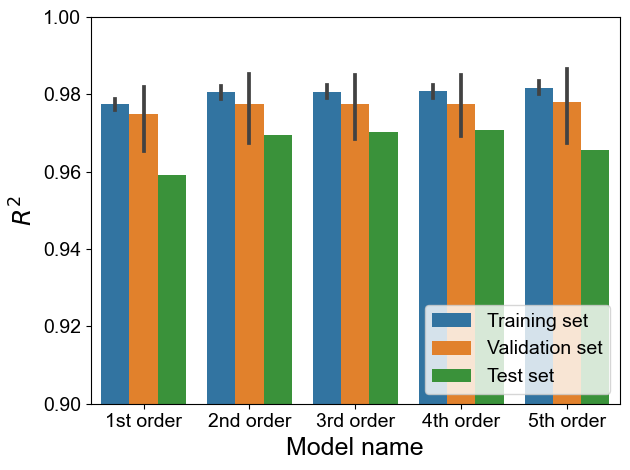

In [7]:
fig = plt.figure()
sns.barplot(data=df_final, x='Model_name', y='R2', hue='Data source')
plt.ylim([0.9, 1.])
plt.legend(fontsize=14, loc=4)
plt.xlabel('Model name', fontsize=18)
plt.ylabel(r'$R^2$', fontsize=18)
plt.tick_params(labelsize=14)
plt.tight_layout()

In [8]:
df_final[(df_final['Model_name'] == '1st order') & (df_final['Data source'] == 'Test set')].describe().iloc[1]

R2    0.959103
Name: mean, dtype: float64

In [9]:
df_final[(df_final['Model_name'] == '2nd order') & (df_final['Data source'] == 'Test set')].describe().iloc[1]

R2    0.969485
Name: mean, dtype: float64

In [10]:
df_final[(df_final['Model_name'] == '3rd order') & (df_final['Data source'] == 'Test set')].describe().iloc[1]

R2    0.970266
Name: mean, dtype: float64

In [11]:
df_final[(df_final['Model_name'] == '4th order') & (df_final['Data source'] == 'Test set')].describe().iloc[1]

R2    0.970802
Name: mean, dtype: float64

In [12]:
df_final[(df_final['Model_name'] == '5th order') & (df_final['Data source'] == 'Test set')].describe().iloc[1]

R2    0.965631
Name: mean, dtype: float64